In [1]:
import csv
import yaml
import glob
import os
import json
import nltk
import re
import shutil
import string
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from keras import models, layers, preprocessing as kprocessing
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from random import sample
from collections import defaultdict
from swda import Transcript
from swda import CorpusReader
from operator import itemgetter
from statistics import mean

2022-06-25 00:25:28.471172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 00:25:28.471192: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#input path
datasets_path = 'data/preprocessed_datasets/'

#output paths
res_intent_path = 'data/result_intents/'
res_hobbie_path = 'data/result_hobbies/'

if not os.path.exists(res_intent_path): os.makedirs(res_intent_path)
if not os.path.exists(res_hobbie_path): os.makedirs(res_hobbie_path)

result = defaultdict(set)

In [3]:
# mapping of different intent names from datasets to standardized names

intent_group = {
    'Answer my question' : 'answer_my_question',
    'fa' : 'im_sorry',
    'You Are Welcome' : 'you_are_welcome',
    'wait' : 'wait',
    'Sure' : 'are_you_sure',
    'mood_unhappy' : 'mood_unhappy',
    'mood_angry' : 'mood_angry',
    'mood_scared' : 'mood_scared',
    'mood_nervous' : 'mood_nervous',
    'mood_excited' : 'mood_excited',
    'mood_lonely' : 'mood_lonely',
    'mood_tired' : 'mood_tired',
    'Clever' : 'you_are_clever',
    'TimeQuery' : 'tell_me_time',
    'listOfGames' : 'list_of_games',
    'playOtherGame' : 'play_other_game',
    'volumeUp' : 'volume_up',
    'volumeDown' : 'volume_down',
    'WhoAmI' : 'who_am_i',
    'music_likeness' : 'music_likeness',
    'music_dislikeness' : 'music_dislikeness',
    'ba' : 'appreciation',
    'general_praise' : 'general_praise',
    'Reaction - Positive' : 'positive_reaction',
    'Reaction - Negative' : 'negative_reaction',
    'general_negate' : 'youre_not_correct',
    'NotTalking2U' : 'NotTalking2U'
}

# some intents have many different names in different datasets, so we map all of them to a standardized one

for key in ['Bot Bad', 'Crazy', 'Annoying', 'Care the Language', 'Bad']:
    intent_group[key] = 'bot_bad'

for key in ['Thanks', 'Well Done', 'General - Thanks', 'ft']:
    intent_group[key] = 'thanks'

for key in ['Bot Affection', 'Good', 'Marry', 'Friend']:
    intent_group[key] = 'bot_affection'

for key in ['yesNode', 'Confirmation Yes', 'ny', 'General - Ok', 'aa']:
    intent_group[key] = 'yes_agree'
    
for key in ['Right', 'affirm_smalltalk', 'general_affirm']:
    intent_group[key] = 'affirm_correct'
    
for key in ['deny_smalltalk', 'noNode', 'General - Not', 'wrong', 'Confirmation No', 'nn']:
    intent_group[key] = 'no_deny_wrong'
    
for key in ['I do not care', 'Reaction - Indifferent', 'maybeNode', 'general_dontcare']:
    intent_group[key] = 'i_dont_care'
    
for key in ['Be clever', 'ad']:
    intent_group[key] = 'bot_action_directive'
    
for key in ['No Problem', 'Reaction - Understanding']:
    intent_group[key] = 'no_problem'
    
for key in ['stop', 'General - Stop', 'Confirmation Cancel', 'totalStop', 'Shutup', 'general_commandstop']:
    intent_group[key] = 'stop'
    
for key in ['greet_smalltalk', 'general_greet', 'Welcome', 'Good Morning', 'Good Evening', 'Greetings - Nice to see you', 'Greetings - Nice to talk to you', 'Greetings - Nice to meet you', 'Greeting']:
    intent_group[key] = 'greetings'
    
for key in ['goodbyes_smalltalk', 'Good Night', 'General - Bye', 'GoodBye', 'CourtesyGoodBye']:
    intent_group[key] = 'goodbye'
    
for key in ['How are you', 'Greetings - Whatsup', 'CourtesyGreeting']:
    intent_group[key] = 'how_are_you'
    
for key in ['Explain', 'general_explain']:
    intent_group[key] = 'explain'
    
for key in ['Repeat', 'general_repeat']:
    intent_group[key] = 'repeat'

for key in ['^g', 'bk', 'bh']:
    intent_group[key] = 'response_acknowledgement'
    
for key in ['There', 'stillThere', 'Ready']:
    intent_group[key] = 'are_you_there'
    
for key in ['Bot Identity', 'Author', 'Agent Name', 'NameQuery', 'RealNameQuery', 'SelfAware']:
    intent_group[key] = 'bot_identity'

for key in ['Acquaintance', 'Occupation', 'Bot Purpose']:
    intent_group[key] = 'bot_purpose'

for key in ['bot_challenge', 'Chatbot', 'Real']:
    intent_group[key] = 'bot_challenge'
    
for key in ['mood_happy', 'Enjoyment']:
    intent_group[key] = 'mood_happy'
    
for key in ['mood_bored', 'Boring']:
    intent_group[key] = 'mood_bored'
    
for key in ['Jokes', 'general_joke']:
    intent_group[key] = 'tell_me_joke'
    
for key in ['timesPlayed', 'gamesCounter']:
    intent_group[key] = 'times_played'

# Data processing

To process SWDA data, you need to place the original SWDA dataset in the root project folder and run copy_files() to copy data with relevant topics to preprocessed datasets folder (if you change swda topics) or you need to place the preprocessed version in data/preprocessed_datasets/ (if you do not change swda topics).\
\
To process other datasets, you need to put the preprocessed versions of them in data/preprocessed_datasets/ .

## 1. SWDA

In [4]:
### print all swda topics

all_swda_topics = set()

#read metadata
#metadata = csv.reader(open('swda/swda-metadata.csv'))
metadata = csv.reader(open(datasets_path + '1_SWDA/swda-metadata.csv'))

#skip first row
header = next(metadata)

#collect all unique topic names
for row in metadata:
    topic = row[3]
    all_swda_topics.add(topic)

print(all_swda_topics)

{'FAMILY LIFE', 'GUN CONTROL', 'VACATION SPOTS', 'HOUSES', 'RECIPES/FOOD/COOKING', 'RESTAURANTS', 'PUERTO RICAN STTEHD', 'COMPUTERS', 'UNIVERSAL HEALTH INS', 'BOATING AND SAILING', 'IMMIGRATION', 'EXERCISE AND FITNESS', 'MAGAZINES', 'RECYCLING', 'AIR POLLUTION', 'AIDS', 'FEDERAL BUDGET', 'CREDIT CARD USE', 'TRIAL BY JURY', 'HOBBIES AND CRAFTS', 'SOVIET UNION', 'CAPITAL PUNISHMENT', 'BUYING A CAR', 'BOOKS AND LITERATURE', 'TV PROGRAMS', 'RIGHT TO PRIVACY', 'NEWS MEDIA', 'MUSIC', 'ELECTIONS AND VOTING', 'GARDENING', 'CAMPING', 'WOODWORKING', 'BASEBALL', 'BASKETBALL', "WOMEN'S ROLES", 'PAINTING', 'CHOOSING A COLLEGE', 'UNIVERSAL PBLIC SERV', 'FAMILY REUNIONS', 'ETHICS IN GOVERNMENT', 'CHILD CARE', 'HOME REPAIRS', 'POLITICS', 'WEATHER CLIMATE', 'DRUG TESTING', 'AUTO REPAIRS', 'CARE OF THE ELDERLY', 'CONSUMER GOODS', 'JOB BENEFITS', 'SPACE FLIGHT AND EXPLORATION', 'PETS', 'TAXES', 'MOVIES', 'FISHING', 'SVGS & LOAN BAILOUT', 'GOLF', 'SOCIAL CHANGE', 'CRIME', 'FAMILY FINANCE', 'LATIN AMERICA'

In [5]:
#list of relevant topics
swda_topics = ['VACATION SPOTS', 'MUSIC', 'BOOKS AND LITERATURE', 'CAMPING', 'MOVIES', 'PETS', 'FAMILY LIFE', 
              'EXERCISE AND FITNESS', 'HOBBIES AND CRAFTS', 'BASEBALL', 'FISHING', 'FOOTBALL', 'RESTAURANTS', 
              'BASKETBALL', 'GARDENING', 'PAINTING', 'GOLF', 'FAMILY REUNIONS', 'BOATING AND SAILING', 'WOODWORKING']

#names for output hobby files
hobbies = [topic.replace(' ', '_') for topic in swda_topics]

In [6]:
### copy files with relevant topics from swda/ to data/preprocessed_datasets/

def copy_files():
    
    out_files_path = datasets_path + '1_SWDA/'
    if not os.path.exists(out_files_path):
        os.makedirs(out_files_path)
    
    # copy metadata
    old_metadata_path = 'swda/swda-metadata.csv'
    shutil.copy2(old_metadata_path, metadata_path)
    metadata = csv.reader(open(metadata_path))
    header = next(metadata)

    for row in metadata:
        topic = row[3]
        
        # copy file only if it has relevant topic
        if topic in swda_topics:
            swda_file_path = glob.glob('swda/*/*' + row[0] + '.utt.csv')

            if swda_file_path:
                shutil.copy2(swda_file_path[0], out_files_path + topic.replace(' ', '_') + '_' + row[0] + '.csv') 

In [7]:
#copy_files()

### Process hobbies

In [8]:
def write_hobbies():
    
    swda_act_dict = {
        "sv": "Statement-opinion",
        "sd": "Statement-non-opinion",
        "qy": "Yes-No-Question",
        "qy^d": "Declarative Yes-No-Question",
        "qw": "Wh-Question",
        "arp_nd": "Dispreferred answers",
    }
    
    for hobbie in hobbies:
        res_hobbies = defaultdict(set)
        
        #get paths of all copied files 
        hobbie_paths = glob.glob(files_path + hobbie + '*')

        for hobbie_path in hobbie_paths:
            
            #read file
            trans = Transcript(hobbie_path, metadata_path)
            #split it into lines
            intent_n_examples = list(trans.utterances)

            for intent in intent_n_examples:
                #get standardized name of intent (if original name is not in swda_act_dict then it's irrelevant)
                intent_name = swda_act_dict.get(intent.damsl_act_tag(), 'irrelevant')

                if intent_name != 'irrelevant':
                    intent_text = intent.text
                    intent_text = re.sub("([\{\<\(]).*?([\}\>\)])", "", intent_text)
                    intent_text = re.sub("([/\[\]\(\)\<\>\+\-#])", "", intent_text)
                    intent_text = intent_text.replace('s1', '')
                    intent_text = intent_text.replace('s2', '')
                    intent_text = re.sub(" +", " ", intent_text)
                    intent_text = intent_text.lstrip(', .')
                    intent_text = intent_text.strip()
                    
                    #add example to dictionary (only if it's long enough and has letters)
                    if len(intent_text) > 10 and re.search('[a-zA-Z]', intent_text):
                        res_hobbies[intent_name].add(intent_text)
        #write result on disk
        with open(res_hobbie_path + hobbie + '.yml', 'w') as outfile:
            yaml.dump(res_hobbies, outfile, default_flow_style=False)

In [9]:
def read_hobbies(file_path):
    
    with open(file_path, 'r') as stream:
        for x in range(4): next(stream)
        return yaml.safe_load(stream)

In [10]:
#write_hobbies()
#res_hobbies = defaultdict(set)
#res_hobbies = read_hobbies(res_hobbie_path + 'MUSIC.yml')
#res_hobbies['Statement-non-opinion']

### Process intents

In [11]:
def trim_intent(intent_text):
    result_intent = intent_text.lower()
    
    #remove everything inside brackets
    result_intent = re.sub("([\{\<\(]).*?([\}\>\)])", "", result_intent)
    
    #remove brackets and punctuation marks (leave '?')
    result_intent = re.sub("([/,\.\[\]\(\)\<\>\+\-#])", "", result_intent)
    
    #some examples contain s1/s2 (speaker1/speaker2)
    result_intent = result_intent.replace('s1', '')
    result_intent = result_intent.replace('s2', '')
    
    #some examples contain names. Maybe more names should be added here
    result_intent = result_intent.replace('olly', '') 
    
    #remove extra spaces
    result_intent = re.sub(" +", " ", result_intent)
    result_intent = result_intent.strip()
    return result_intent

In [12]:
def process_1_swda():
    files_path = datasets_path + '1_SWDA/'
    metadata_path = files_path + 'swda-metadata.csv'

    for hobbie in hobbies:
        #get paths of all copied files
        hobbie_paths = glob.glob(files_path + hobbie + '*')

        for hobbie_path in hobbie_paths:
            #read file
            trans = Transcript(hobbie_path, metadata_path)
            
            #split it into lines
            intent_n_examples = list(trans.utterances)

            for intent in intent_n_examples:
                #get standardized name of intent (if original name is not in intent_group then it's irrelevant)
                intent_name = intent_group.get(intent.damsl_act_tag(), 'irrelevant')
                
                #trim example
                intent_text = trim_intent(intent.text)

                #add example to dictionary (only if it's relevant, long enough and has letters)
                if intent_name != 'irrelevant' and re.search('[a-zA-Z]', intent_text) and len(intent_text) < 50:
                    result[intent_name].add(intent_text)

## 2. RasaHQ

In [13]:
def process_2_rasaHQ():
    
    #get paths of all files
    file_paths = glob.glob(datasets_path + '2_RasaHQ/*/*.yml')

    for file_path in file_paths:
        #read file
        with open(file_path, 'r') as file:
            parsed_file = yaml.safe_load(file)
        
        intents_n_examples = parsed_file["nlu"]
        
        for intent in intents_n_examples:
            #get standardized name of intent (if original name is not in intent_group then it's irrelevant)
            intent_name = intent_group.get(intent['intent'], 'irrelevant')
            
            #separate examples from each other
            rough_examples = intent['examples'].split('\n')
            
            #trim every example
            examples = [trim_intent(ex) for ex in rough_examples][:-1]
            
            #add all examples to dictionary (only if it's relevant)
            if intent_name != 'irrelevant':
                result[intent_name].update(examples)

## 3. Chatbot Dialog Dataset

In [14]:
def process_3_dialog_dataset():
    
    #get paths of all files
    file_path = datasets_path + '3_Chatbot_Dialog_Dataset/'

    for file in os.listdir(file_path):
        #get intent name from file name and get standardized name for it
        intent_name = intent_group.get(str(file).split('.')[0], 'irrelevant')
        
        #separate examples from each other
        rough_examples = open(file_path + file, "r").read().split("\n")
        
        #trim every example
        examples = [trim_intent(ex) for ex in rough_examples]
        
        #add all examples to dictionary (only if it's relevant)
        if intent_name != 'irrelevant':
            result[intent_name].update(examples)

## 4. Chatbot Intent Classification

In [15]:
def process_4_intent_classification():
    
    #get paths of all files
    file_path = datasets_path + '4_Chatbot_Intent_Classification/intent-corpus-basic.json'

    with open(file_path, 'r') as file:
        data = json.load(file)

    intents_n_examples = data['sentences']
    for intent in intents_n_examples:
        #get standardized name of intent (if original name is not in intent_group then it's irrelevant)
        intent_name = intent_group.get(intent['intent'], 'irrelevant')
        example = trim_intent(intent['text'])
        
        #add example to dictionary (only if it's relevant and has letters)
        if intent_name != 'irrelevant' and re.search('[a-zA-Z]', example):
            result[intent_name].add(example)

## 5. Chatbot Intent Recognition

In [16]:
def process_5_intent_recognition():    
    
    #get paths of all files
    file_path = datasets_path + '5_Chatbot_Intent_Recognition/Intent.json'

    with open(file_path, 'r') as file:
        data = json.load(file)

    intents_n_examples = data['intents']
    for intent in intents_n_examples:
        #get standardized name of intent (if original name is not in intent_group then it's irrelevant)
        intent_name = intent_group.get(intent['intent'], 'irrelevant')

        rough_examples = intent['text']
        
        #trim every example
        examples = [trim_intent(ex) for ex in rough_examples]
        
        #add all examples to dictionary (only if it's relevant)
        if intent_name != 'irrelevant':
            result[intent_name].update(examples)

## 6. HWU64

In [17]:
def process_6_hwu64():
    
    #get paths of all files
    file_path = datasets_path + '6_HWU64/NLU-Data-Home-Domain-Annotated-All.csv'

    file = open(file_path)    
    data = csv.reader(file)

    header = next(data)
    
    #header row from HWU64:
    #userid;answerid;scenario;intent;status;answer_annotation;notes;suggested_entities;answer_normalised;answer;question
    
    #example row from HWU64:
    #2;588;music;likeness;null;i like [music_genre : rock] music;null;music_genre, person, preference, song_name;i like rock music;I like rock music;How would you tell your PDA about the music you like?"
    
    for row in data:
        #this example row will be splitted into list by ',' so we recreate row and split it by ';' instead
        clean_row = ','.join(map(str, row)).split(';')
        
        # for this example row intent name will be 'music_likeness'
        intent_name = intent_group.get(clean_row[2] + "_" + clean_row[3], 'irrelevant')
        
        example = trim_intent(clean_row[9])

        #add example to dictionary (only if it's relevant and has letters)
        if intent_name != 'irrelevant' and re.search('[a-zA-Z]', example):
            result[intent_name].add(example)

In [18]:
### write intents

def write_results():
    for intent_group in result.keys():
        with open(res_intent_path + intent_group + '.yml', 'w') as outfile:
            yaml.dump(result[intent_group], outfile, default_flow_style=False)

In [19]:
#process_1_swda()
#process_2_rasaHQ()
#process_3_dialog_dataset()
#process_4_intent_classification()
#process_5_intent_recognition()
#process_6_hwu64()
#write_results()

# Transfer learning

In [20]:
### read intents

def read_intents(file_path):  
    with open(file_path, 'r') as stream:
        return yaml.safe_load(stream)

In [21]:
result = defaultdict(set)

file_paths = glob.glob(res_intent_path + '*.yml')

#each intent has its own file with examples so we read all of them

for file_path in file_paths:
    intents = read_intents(file_path)
    
    #get intent name from file name
    intent_group = file_path.replace(res_intent_path, '').replace('.yml', '')
    result[intent_group] = intents

In [22]:
# get intent name with number of samples for each intent (only if there are >55 samples)
intent_group_n = [(len(result[key]), key) for key in result.keys() if len(result[key]) > 55]

# sort it by number of samples
intent_group_n.sort(key=lambda key: key[0])

print('number of intents:', len(intent_group_n))
print('smallest sets:', intent_group_n[:5])
print('biggest sets:', intent_group_n[-5:])

# get only intent names (that have >55 examples)
intent_groups = [key[1] for key in intent_group_n]

number of intents: 27
smallest sets: [(61, 'bot_identity'), (66, 'list_of_games'), (68, 'thanks'), (74, 'volume_up'), (91, 'bot_purpose')]
biggest sets: [(601, 'repeat'), (627, 'general_praise'), (633, 'explain'), (939, 'youre_not_correct'), (956, 'yes_agree')]


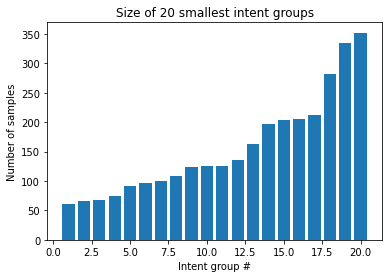

In [23]:
plt.bar(range(1,21), [key[0] for key in intent_group_n][:20])
plt.title('Size of 20 smallest intent groups')
plt.ylabel('Number of samples')
plt.xlabel('Intent group #')
plt.show()

In [24]:
interjections = ['hmm ', 'ah ', 'oh ', 'uh ', 'uhh ', 'hey ']

for group_n in intent_group_n:
    if group_n[0] < 250:
    
        #if num of examples <150 duplicate ~all of them
        #if num of examples >150 and <250 duplicate ~half of them
        frac = 0.95 if group_n[0] < 150 else 0.55
        group_name = group_n[1]
        new_samples = sample(result[group_name], int(frac * group_n[0]))
        
        #add random interjection at the beginning of duplicated examples
        new_samples_aug = [sample(interjections, 1)[0] + samp for samp in new_samples]
        
        result[group_name].update(new_samples_aug)

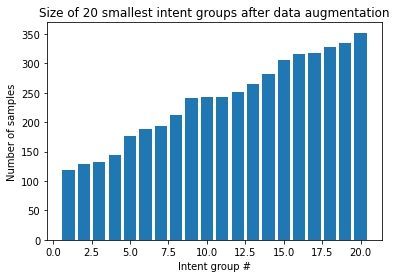

In [25]:
augmented_data_stats = [len(result[key]) for key in result.keys() if len(result[key]) > 55]
augmented_data_stats.sort()

plt.bar(range(1,21), augmented_data_stats[:20])
plt.title('Size of 20 smallest intent groups after data augmentation')
plt.ylabel('Number of samples')
plt.xlabel('Intent group #')
plt.show()

In [26]:
xx = []
yy = []

#put all examples into xx and corresponding index numbers of intents into yy
#for instance, xx=[hello, hi, bye, goodbye] yy=[0,0,1,1]

for i, intent in enumerate(intent_groups):
    x_new = result[intent]
    y_new = [i] * len(x_new)
    xx += x_new
    yy += y_new

#shuffle, keeping pairs of xx and yy 
xx_yy = list(zip(xx, yy))
random.shuffle(xx_yy)
xx, yy = zip(*xx_yy)
    
x = np.array(xx)
y = np.array(yy)

In [27]:
#load MUSE model
model_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
#and use it as keras layer
hub_layer = hub.KerasLayer(model_url, input_shape=[], dtype=tf.string, trainable=False)

2022-06-25 00:27:03.462247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-25 00:27:03.462277: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-25 00:27:03.462290: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubu): /proc/driver/nvidia/version does not exist
2022-06-25 00:27:03.462449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(len(intent_groups), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               68927232  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                                 
Total params: 68,996,379
Trainable params: 69,147
Non-trainable params: 68,927,232
_________________________________________________________________


In [29]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
training_results = model.fit(x=x, y=y, batch_size=64, epochs=50, shuffle=True, verbose=1, callbacks=[earlyStopping], validation_split=0.2)

Epoch 1/50
121/121 [==============================] - 6s 26ms/step - loss: 2.2833 - accuracy: 0.4589 - val_loss: 1.3912 - val_accuracy: 0.6625
Epoch 2/50
121/121 [==============================] - 3s 22ms/step - loss: 1.0534 - accuracy: 0.7234 - val_loss: 0.8571 - val_accuracy: 0.7814
Epoch 3/50
121/121 [==============================] - 3s 23ms/step - loss: 0.7551 - accuracy: 0.7935 - val_loss: 0.6979 - val_accuracy: 0.8124
Epoch 4/50
121/121 [==============================] - 2s 20ms/step - loss: 0.6390 - accuracy: 0.8121 - val_loss: 0.6287 - val_accuracy: 0.8258
Epoch 5/50
121/121 [==============================] - 2s 20ms/step - loss: 0.5716 - accuracy: 0.8265 - val_loss: 0.5870 - val_accuracy: 0.8258
Epoch 6/50
121/121 [==============================] - 3s 21ms/step - loss: 0.5256 - accuracy: 0.8372 - val_loss: 0.5550 - val_accuracy: 0.8289
Epoch 7/50
121/121 [==============================] - 2s 20ms/step - loss: 0.4887 - accuracy: 0.8432 - val_loss: 0.5354 - val_accuracy: 0.8377

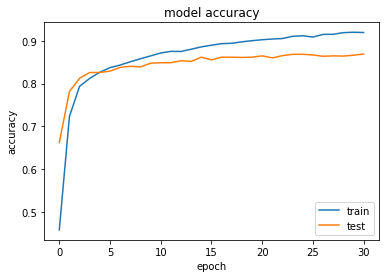

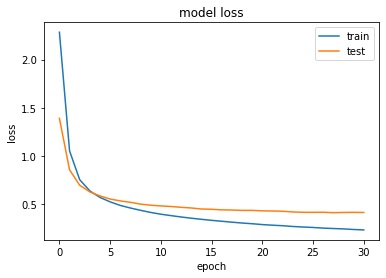

In [30]:
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(training_results.history['loss'])
plt.plot(training_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [31]:
#lists of test sentences in Dutch for each intent
nl_test_bot_identity = ['uhh wie is je ontwikkelaar?', 'hoe kan ik je bellen', 'wat is je bijnaam ook alweer', 'wat is je echte naam?', 'vertel me je naam?']
nl_test_thanks = ['nou bedankt', 'uhh bedankt voor je hulp', 'hey goed werk', 'uh heel erg bedankt', 'Bravo']
nl_test_volume_up = ['zal hoger spreken', 'kun je harder praten?', 'je praat te stil', 'uh zou je harder kunnen praten', 'ah ik kan je niet goed horen']
nl_test_volume_down = ['zou minder hard praten', 'zal stil praten', 'ah wil je stil praten?', 'kan rustig praten', 'wil je stiller praten?']
nl_test_bot_purpose = ['uh wat is je doel?', 'wat ben je', 'Ben jij een robot?', 'bot of mens?', 'vertel me over jou']
nl_test_greetings = ['o blij je te zien', 'Aangenaam', 'Hallo daar', 'ik ben blij je weer te zien', 'oh goede dag']
nl_test_goodbye = ['oke ik zie je later', 'Welterusten', 'oke doei', 'spreek je later', 'tot ziens']
nl_test_bot_bad = ['je bent een verspilling', 'dit is niet goed', 'Jij bent erg vervelend', 'uh let alsjeblieft op je taal', 'hey je bent gek']
nl_test_tell_me_joke = ['ah vertel me iets grappigs', 'uh ik wil een grap horen', 'uhh ik wil wel een grapje', 'vind een grap in je kluis en vertel het me', 'ah vertel me een willekeurige grap']
nl_test_list_of_games = ['welk spel kunnen we spelen?', 'hey wat kun je nog meer spelen?', 'oh welke games zijn beschikbaar?', 'uhh welk spel ken jij?', 'welk ander spel heb je?']
nl_test_play_other_game = ['ik wil andere spellen openen', 'een ander spel openen', 'hey stop dit spel', 'ik wil dit spel niet spelen', 'laten we wat andere spellen beginnen']
nl_test_response_acknowledgement = ['O ja?', 'je doet?', 'uhh ik zie het', 'denk het?', 'is dat juist']
nl_test_bot_action_directive = ['waarom begin je niet?', 'eh ga door', 'noem maar op', 'hey je moet leren', 'je zou dat kunnen proberen']
nl_test_bot_affection = ['je werkt goed', 'ik vind jou ook leuk', 'trouw met me alsjeblieft', 'jij bent goed', 'ah vind je erg leuk']
nl_test_music_likeness = ['het lied raakt mijn hart', 'hey dit is een vijf sterren nummer!', 'het nummer dat je speelt is geweldig', 'ah ik hou van muziek uit de jaren 80', 'dit is een leuk liedje']
nl_test_negative_reaction = ['wil je dit oplossen?', 'hey ik heb een probleem', 'erger dan ik dacht', 'dit is zo saai', 'behoorlijk slecht']
nl_test_positive_reaction = ['briljant', 'het is zeer goed', 'dat is een goed idee', 'ah geweldig', 'Super geweldig']
nl_test_no_deny_wrong = ['oh nee ik niet', 'niet correct', 'ik heb er geen', 'niet echt', 'niet dit']
nl_test_stop = ['annuleer mijn verzoek', 'wil je alsjeblieft afsluiten', 'niets doen', 'ik wil stoppen', 'wil je er alsjeblieft mee stoppen']
nl_test_i_dont_care = ['vind het echt niet erg', 'zou het niet erg vinden om er een te selecteren', 'iedereen is in orde met mij', 'het kan me niet echt schelen', 'alles is oké voor mij']
nl_test_appreciation = ['leuk', 'dat klinkt best netjes', 'dat klinkt zo mooi', 'dat is veel werk', 'dat is geweldig']
nl_test_affirm_correct = ['je hebt helemaal gelijk', 'het is de waarheid', 'snap het perfect', 'ja je hebt het antwoord precies', 'commando was exact']
nl_test_repeat = ['vertel me nog een keer de laatste alsjeblieft', 'zou je alsjeblieft je laatste zin willen herhalen?', 'stop en probeer het opnieuw', 'laten we het alsjeblieft nog een keer proberen', 'vertel me alsjeblieft nog een keer']
nl_test_general_praise = ['prachtig werk heb je goed gedaan', 'je hebt het goed gedaan bedankt', 'dat is handig dankjewel', 'dat heb je goed gedaan heel erg bedankt', 'dat heb je goed gedaan, ik waardeer het']
nl_test_explain = ['kunt u alstublieft nogmaals verduidelijken?', 'leg verder uit aub', 'het was me niet duidelijk', 'wat bedoelde je ermee?', 'kun je me verder herformuleren op je antwoorden?']
nl_test_youre_not_correct = ['ik heb hier niet om gevraagd', 'het lijkt erop dat het antwoord niet juist was', 'het spijt me maar dat was niet goed', 'uw opdracht was onjuist', 'het spijt me maar dat is niet het juiste antwoord']
nl_test_yes_agree = ['Ja', 'ik ben het er zeker mee eens', 'positief', 'oh ik denk dat', 'oh ja waarschijnlijk']

In [32]:
#lists of test sentences in Russian for each intent
ru_test_bot_identity = ['я забыл твое имя', 'можешь подсказать свое имя?', 'кто ты?', 'кто создал тебя?', 'как мне стоит называть тебя?']
ru_test_thanks = ['нет, спасибо, это все', 'большое спасибо', 'благодарю', 'отличная работа!', 'я ценю твою помощь']
ru_test_volume_up = ['хмм а не мог бы ты говорить погромче?', 'а можно повысить громкость?', 'я не слышу тебя', 'можешь разговаривать громче?', 'ты говоришь очень тихо']
ru_test_volume_down = ['говори потише', 'ты слишком громкий', 'убавь громкость', 'ты можешь говорить тихо?',  'можно говорить не так громко?']
ru_test_bot_purpose = ['ты можешь мне помочь?', 'как это работает?', 'ты робот?', 'ты настоящий?', 'что ты такое?']
ru_test_greetings = ['очень рад видеть тебя', 'доброе утро', 'привет', 'доброго дня', 'приветствую!']
ru_test_goodbye = ['прощай', 'спасибо, до свидания', 'пока-пока', 'всего хорошего', 'увидимся позже!']
ru_test_bot_bad = ['ты очень плохой', 'ты сошел с ума', 'очень плохо', 'хм, это было ужасно', 'ты просто мусор']
ru_test_tell_me_joke = ['расскажи мне шутку', 'хей ну ка расскажи анекдот', 'ты знаешь какие-нибудь шутеечки?', 'мм я хотел бы услышать шутку', 'я хочу услышать что-нибудь смешное']
ru_test_list_of_games = ['во что я могу поиграть?', 'о, какие игры у тебя есть?', 'в какие игры ты умеешь играть?', 'а в какую игру мы можем поиграть?', 'ммм какие игры доступны?']
ru_test_play_other_game = ['нуу давай сыграем в другую игру', 'давай еще поиграем', 'играем еще', 'я хочу сыграть еще одну игру', 'я хочу начать новую игру']
ru_test_response_acknowledgement = ['правда?', 'действительно?', 'это правильно?', 'не так ли?', 'ух ты']
ru_test_bot_action_directive = ['тебе стоит попробовать', 'ты хочешь начать первым?', 'Вам стоит попытаться', 'тебе нужно научиться этому', 'продолжай']
ru_test_bot_affection = ['ты хорошо работаешь', 'ты хороший', 'Ты мне тоже нравишься', 'ах ты мне очень нравишься', 'женись на мне, пожалуйста']
ru_test_music_likeness = ['а мне нравится музыка 90-х', 'эта песня трогает мое сердце', 'песня, которую ты играешь, потрясающая', 'это хорошая песня', 'Эй, это пятизвездочная песня!']
ru_test_negative_reaction = ['хуже, чем я думал', 'это так скучно', 'ты исправишь это', 'довольно плохо', 'эй у меня проблема']
ru_test_positive_reaction = ['это хорошая идея', 'ах удивительно', 'это очень хорошо', 'супер классно', 'блестяще']
ru_test_no_deny_wrong = ['неправильно', 'У меня нет', 'о нет, я не', 'не совсем', 'не то']
ru_test_stop = ['отменить мой запрос', 'не могли бы вы выключить', 'ничего не делать', 'я хочу остановить это', 'пожалуйста, просто прекрати это']
ru_test_i_dont_care = ['мне все равно', 'мне действительно без разницы', 'не против выбрать любой', 'я согласен на любое', 'любое окей для меня']
ru_test_appreciation = ['это звучит так красиво', 'красивый', 'это много работы', 'это великолепно', 'это звучит довольно аккуратно']
ru_test_affirm_correct = ['вы совершенно правы', 'это правда', 'ваш ответ отличный', 'да вы точно ответили', 'команда была точной']
ru_test_repeat = ['не могли бы вы повторить то, что вы сказали', 'можешь повторить?', 'попробуем еще раз', 'пожалуйста, скажи мне еще раз', 'Я хотел бы снова услышать последнюю фразу' ]
ru_test_general_praise = ['Спасибо за ваш ответ', 'это отличная работа', 'это полезно, я ценю это', 'это полезно, большое спасибо', 'молодец спасибо']
ru_test_explain = ['пожалуйста, поясните мне свои ответы', 'объясни свой ответ мне еще раз, пожалуйста', 'я не совсем это понял', 'Я не понимаю твоих слов', 'я не понимаю этого']
ru_test_youre_not_correct = ['сделай это как-то по-другому', 'я думаю, что ты сделал задание неправильно', 'извините, но это не правильный ответ', 'нет, ты не понял что я спросил', 'ты сделал что-то не так']
ru_test_yes_agree = ['звучит правильно', 'о да, абсолютно', 'о да, вроде того', 'это возможно', 'думаю да']

In [33]:
#not used
#can be used to see confidence of model predictions
def predict_top3_with_conf(value):
    #get intent predictions for a sentence
    vals = model.predict(np.array([value.lower()]))[0]
    
    #sort them by confidence of model, keep top3 of them and get their standardized names and confidence
    result = [(intent_groups[i], vals[i]) for i in sorted(range(len(vals)), key=lambda i: vals[i])[-3:]]
    result.reverse()
    return result

predict_top3_with_conf('oh ik denk dat')

[('yes_agree', 0.8123863),
 ('appreciation', 0.15783218),
 ('response_acknowledgement', 0.0227847)]

In [34]:
def predict_top3(value):
    #get intent predictions for a sentence
    vals = model.predict(np.array([value.lower()]))[0]
    
    #sort them by likelihood of intent, keep top3 of them and get their standardized names
    result = [intent_groups[i] for i in sorted(range(len(vals)), key=lambda i: vals[i])[-3:]]
    result.reverse()
    return result

In [35]:
def test_intent(intent, samples):
    correct_count = 0
    in_top3_count = 0
    predicted_instead = []
    print('Testing intent: ' + intent)
    for sample in samples:
        predicted_top3 = predict_top3(sample)
        
        # if predicted correctly
        if intent == predicted_top3[0]: 
            correct_count += 1
        else:
            # if predicted not correctly but in top3
            if intent in predicted_top3:
                in_top3_count += 1
            # show what was predicted instead if predicted not correctly
            predicted_instead.append(predicted_top3[0])
            #print('###', sample, '===', predicted_top3[0])

    correct_pct = round(correct_count/len(samples) * 100)
    top3_pct = round(in_top3_count/len(samples) * 100)
    print('correct intents predicted: ', correct_pct, '%')
    print('not correct but in top 3: ', top3_pct, '%')
    print('intents that were predicted instead:', predicted_instead)
    print('--------------------------------')
    return (correct_pct, top3_pct)

In [36]:
test_results = []
test_results.append(test_intent('bot_identity', ru_test_bot_identity + nl_test_bot_identity))
test_results.append(test_intent('thanks', ru_test_thanks + nl_test_thanks))
test_results.append(test_intent('volume_up', ru_test_volume_up + nl_test_volume_up))
test_results.append(test_intent('volume_down', ru_test_volume_down + nl_test_volume_down))
test_results.append(test_intent('bot_purpose', ru_test_bot_purpose + nl_test_bot_purpose))
test_results.append(test_intent('greetings', ru_test_greetings + nl_test_greetings))
test_results.append(test_intent('goodbye', ru_test_goodbye + nl_test_goodbye))
test_results.append(test_intent('bot_bad', ru_test_bot_bad + nl_test_bot_bad))
test_results.append(test_intent('tell_me_joke', ru_test_tell_me_joke + nl_test_tell_me_joke))
test_results.append(test_intent('list_of_games', ru_test_list_of_games + nl_test_list_of_games))
test_results.append(test_intent('play_other_game', ru_test_play_other_game + nl_test_play_other_game))
test_results.append(test_intent('response_acknowledgement', ru_test_response_acknowledgement + nl_test_response_acknowledgement))
test_results.append(test_intent('bot_action_directive', ru_test_bot_action_directive + nl_test_bot_action_directive))
test_results.append(test_intent('bot_affection', ru_test_bot_affection + nl_test_bot_affection)) 
test_results.append(test_intent('music_likeness', ru_test_music_likeness + nl_test_music_likeness)) 
test_results.append(test_intent('negative_reaction', ru_test_negative_reaction + nl_test_negative_reaction)) 
test_results.append(test_intent('positive_reaction', ru_test_positive_reaction + nl_test_positive_reaction)) 
test_results.append(test_intent('no_deny_wrong', ru_test_no_deny_wrong + nl_test_no_deny_wrong)) 
test_results.append(test_intent('stop', ru_test_stop + nl_test_stop)) 
test_results.append(test_intent('i_dont_care', ru_test_i_dont_care + nl_test_i_dont_care)) 
test_results.append(test_intent('appreciation', ru_test_appreciation + nl_test_appreciation)) 
test_results.append(test_intent('affirm_correct', ru_test_affirm_correct + nl_test_affirm_correct)) 
test_results.append(test_intent('repeat', ru_test_repeat + nl_test_repeat)) 
test_results.append(test_intent('general_praise', ru_test_general_praise + nl_test_general_praise)) 
test_results.append(test_intent('explain', ru_test_explain + nl_test_explain)) 
test_results.append(test_intent('youre_not_correct', ru_test_youre_not_correct + nl_test_youre_not_correct)) 
test_results.append(test_intent('yes_agree', ru_test_yes_agree + nl_test_yes_agree)) 

correct_results, top3_results = zip(*test_results)
correct_pct = round(mean(correct_results))
top3_pct = round(mean(top3_results))
print('--------------------------------')
print('--------------------------------')
print('Total result:')
print('correct intents predicted:', correct_pct, '%')
print('not correct but in top 3:', top3_pct, '%')
print('top 1 + top 3:', correct_pct + top3_pct, '%')

Testing intent: bot_identity
correct intents predicted:  90 %
not correct but in top 3:  10 %
intents that were predicted instead: ['bot_purpose']
--------------------------------
Testing intent: thanks
correct intents predicted:  80 %
not correct but in top 3:  20 %
intents that were predicted instead: ['appreciation', 'general_praise']
--------------------------------
Testing intent: volume_up
correct intents predicted:  80 %
not correct but in top 3:  10 %
intents that were predicted instead: ['volume_down', 'stop']
--------------------------------
Testing intent: volume_down
correct intents predicted:  60 %
not correct but in top 3:  40 %
intents that were predicted instead: ['volume_up', 'volume_up', 'volume_up', 'repeat']
--------------------------------
Testing intent: bot_purpose
correct intents predicted:  80 %
not correct but in top 3:  0 %
intents that were predicted instead: ['response_acknowledgement', 'tell_me_joke']
--------------------------------
Testing intent: greeti